In [1]:
%load_ext autoreload
%autoreload 2

## New Car Simulation model

This example is based on one in the textbook [Business Analytics: Data Analysis and Decision Making (Albright and Winston)](https://host.kelley.iu.edu/albrightbooks/). This example is in Section 16.3 in the 7th edition. Here's the basic problem (with a few modifications):

* we are developing a new car,
* there's a fixed development cost,
* we have estimated a unit margin per car which decays at a known rate each year,
* demand in the first year is uncertain and we will model it with a triangular distribution,
* demand in years 2 through 5 are based on the previous years demand and a decay rate modeled with another triangular distribution,
* depreciation is modeled using the straight line method and theirs a known fixed tax rate.

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng

# Numpy financial functions have been removed to their own package
# See https://numpy.org/numpy-financial/
import numpy_financial as npf

In [4]:
from whatif import Model
from whatif import get_sim_results_df

ModuleNotFoundError: No module named 'whatif'

In [29]:
%matplotlib inline

## Developing the model

This is the second example model we've created and the first in which computations play out over time. It wasn't exactly clear how to best develop the cash flow model while trying to leverage the foundation we've built with the `whatif.Model` class and using good model building principles.

As with most simulation models, we'll start by building a deterministic model and then add randomness via the `whatif.simulate` function. This mimics the idea of creating a deterministic model in Excel and then modifying it with @Risk functions to do Monte-Carlo simulation.

Typically, in spreadsheet financial models, time periods (e.g. years)
go across the columns and the financial measures go down the rows. Let's
do the same. Some complications that need to be thought through are common to many similar financial models:

* The first year is based on base inputs or functions of other first year values. 
* Subsequent values are based either on previous year along with some multiplier or are functions of other values in the same year.

While I originally thought that the computations would be done using Pandas `Series` and `DataFrame` objects, it ended up being more natural to work with Numpy arrays.

In [62]:
class NewCarModel(Model):
    """New car model

    This example is based on one in the textbook 
    [Business Analytics: Data Analysis and Decision Making (Albright and Winston)
    This example is in Section 16.3 in the 7th edition. Here's the basic problem (with a few modifications):

    * we are developing a new car,
    * there's a fixed development cost,
    * we have estimated a unit margin per car which decays at a known rate each year,
    * demand in the first year is uncertain and we will model it with a triangular distribution,
    * demand in years 2 through 5 are based on the previous years demand and a decay rate modeled with another triangular distribution,
    * depreciation is modeled using the straight line method and theirs a known fixed tax rate.
    
    Attributes
    ----------
    fixed_dev_cost: float, optional
        Development cost (default 600e+6)
    base_margin : float, optional
        Unit margin in year 1 (default 4e+3)
    annual_margin_decr : float, optional
        Fractional annual decrease in unit margin (default 0.04)
    yr1_demand : float, optional
        Number of items ordered in the one time we get to order (default 53560.0)
    demand_decr : float or array-like of float, optional
        Fractional annual decrease in demand (default 0.077)
    tax_rate : float or array-like of float, optional
        Tax rate (default 0.077)
    discount_rate : float, optional
        Used for NPV calculation (default 0.07)
    num_years : int, optional
        Number of years in the model (default 5)
    """
    def __init__(self, fixed_dev_cost=600e+6, base_margin=4e+3, annual_margin_decr=0.04,
                 yr1_demand=53560, demand_decr=0.077,
                 tax_rate=0.21, discount_rate=0.07, num_years=5
                ):
        
        self.fixed_dev_cost = fixed_dev_cost
        self.base_margin = base_margin
        self.annual_margin_decr = annual_margin_decr
        
        self.yr1_demand = yr1_demand
        self.demand_decr = demand_decr

        self.tax_rate = tax_rate
        self.discount_rate = discount_rate
        self.num_years = num_years

    def sales(self):
        """Sales by year
        
        Depends on random base value in year 0 which is then modified by a percent decay rate that may
        vary by year.
        """
    
        # Scalar to range (consider creating function for this)
        if np.isscalar(self.demand_decr):
            self.demand_decr = np.full((1, self.num_years - 1), self.demand_decr)
       
        # This is the key to multi-period models - how to best do this?
        if np.isscalar(self.yr1_demand):
            sales_array = np.zeros((1, self.num_years))
        else:
            sales_array = np.zeros((len(self.yr1_demand), self.num_years))
        
        sales_array[:, 0] = self.yr1_demand

        for t in range(1, self.num_years):
            sales_array[:, t] = (1 - self.demand_decr[:, t - 1]) * sales_array[:, t - 1]
    
        return sales_array
    
    
    def unit_contribution(self):
        """Unit contribution by year
        
        Depends on random base value in year 0 which is then modified by a fixed percent decay rate.
        """
        
        _unit_contribution = np.array([self.base_margin * (1 - self.annual_margin_decr) ** n 
                     for n in range(self.num_years)])
        
        return _unit_contribution
    
    
    def net_revenue(self):
        """Net revenue by year
        
        Sales multiplied by unit_contribution for each year
        """
        
        _net_revenue = self.sales() * self.unit_contribution()
        return _net_revenue
    
    def depreciation(self):
        """Depreciation by year
        
        Assumes straight line depreciation
        """
        
        _depreciation = np.full(self.num_years, self.fixed_dev_cost / self.num_years)
        return _depreciation
    
    def before_tax_profit(self):
        """Before tax profit by year
        
        Net revenue minus depreciation
        """
        
        _before_tax_profit = self.net_revenue() - self.depreciation()
        return _before_tax_profit
    
    def after_tax_profit(self):
        """After tax profit by year
        
        Before tax profit after taxes removed
        """        
        _after_tax_profit = self.before_tax_profit() * (1 - self.tax_rate)
        return _after_tax_profit

    def cash_flow(self):
        """Cash flow by year
        
        After tax profit plus depreciation
        """        
        _cash_flow = self.after_tax_profit() + self.depreciation()
        return _cash_flow
    
    def npv(self):
        """NPV of cash flow adjusted for initial investment
        
        The `numpy_financial.npv()` function wants the initial investment as a
        negative cash flow in year 1 or a zero cash flow in year 1 and then need to
        subtract off the initial investment.
        """        
        
        cash_flow = self.cash_flow()
        # If more than one row in cash_flow, we must be simulating or creating a
        # data table.
        nrows = cash_flow.shape[0]
        
        # Create an (nrows x 1) array filled with initial investment values
        col0 = np.full(nrows, -self.fixed_dev_cost)
        col0 = col0.reshape((nrows, 1))
        
        # Insert the initial investment at start of cash flow stream
        adj_cash_flow = np.concatenate((col0, self.cash_flow()), axis=1)
        
        # Compute npv for each row of cash flow streams
        _npv = np.array([npf.npv(self.discount_rate, adj_cash_flow[i, :]) for i in range(nrows)])
        
        return _npv
    
    def model_to_df(self, transpose=True):
        """Create DataFrame version of financial model table
        
        Financial model table is transposed so that financial measures are columns.
        """         
        X = np.vstack([self.sales(), self.unit_contribution(),
                                    self.net_revenue(), self.depreciation(),
                                    self.before_tax_profit(), self.after_tax_profit(), self.cash_flow()])
        
        if transpose:
            X = np.transpose(X)
            df = pd.DataFrame(X, columns = ['sales', 'unit_contribution', 'net_revenue',
                                       'depreciation', 'before_tax_profit', 'after_tax_profit',
                                       'cash_flow'])
        else:
            df = pd.DataFrame(X, index = ['sales', 'unit_contribution', 'net_revenue',
                                       'depreciation', 'before_tax_profit', 'after_tax_profit',
                                       'cash_flow'])
                         
        return df


## Using the model in deterministic mode

Create a model instance with default parameter values.

In [63]:
model_default = NewCarModel()
print(model_default)

{'fixed_dev_cost': 600000000.0, 'base_margin': 4000.0, 'annual_margin_decr': 0.04, 'yr1_demand': 53560, 'demand_decr': 0.077, 'tax_rate': 0.21, 'discount_rate': 0.07, 'num_years': 5}


Let's explore some of the line items in the model. Notice that time is across columns and the different financial components make up the rows.

In [64]:
print(model_default.sales())
print(model_default.sales().shape)

[[53560.         49435.88       45629.31724    42115.85981252
  38872.93860696]]
(1, 5)


In [65]:
model_default.unit_contribution()

array([4000.     , 3840.     , 3686.4    , 3538.944  , 3397.38624])

In [66]:
model_default.net_revenue()

array([[2.14240000e+08, 1.89833779e+08, 1.68207915e+08, 1.49045669e+08,
        1.32066387e+08]])

In [67]:
model_default.depreciation()

array([1.2e+08, 1.2e+08, 1.2e+08, 1.2e+08, 1.2e+08])

In [68]:
model_default.before_tax_profit()

array([[94240000.        , 69833779.20000002, 48207915.07353601,
        29045669.38835877, 12066386.73163696]])

In [69]:
model_default.after_tax_profit()

array([[74449600.        , 55168685.56800002, 38084252.90809345,
        22946078.81680343,  9532445.5179932 ]])

In [70]:
model_default.cash_flow()

array([[1.94449600e+08, 1.75168686e+08, 1.58084253e+08, 1.42946079e+08,
        1.29532446e+08]])

In [71]:
model_default.npv()

array([65179274.66475619])

It's easier to view the model line items as a DataFrame.

In [72]:
model_default.model_to_df()

,sales,unit_contribution,net_revenue,depreciation,before_tax_profit,after_tax_profit,cash_flow
0,53560.000000,4000.00000,2.142400e+08,120000000.0,9.424000e+07,7.444960e+07,1.944496e+08
1,49435.880000,3840.00000,1.898338e+08,120000000.0,6.983378e+07,5.516869e+07,1.751687e+08
2,45629.317240,3686.40000,1.682079e+08,120000000.0,4.820792e+07,3.808425e+07,1.580843e+08
3,42115.859813,3538.94400,1.490457e+08,120000000.0,2.904567e+07,2.294608e+07,1.429461e+08
4,38872.938607,3397.38624,1.320664e+08,120000000.0,1.206639e+07,9.532446e+06,1.295324e+08


In [73]:
model_default.model_to_df(transpose=False)

,0,1,2,3,4
sales,53560.0,4.943588e+04,4.562932e+04,4.211586e+04,3.887294e+04
unit_contribution,4000.0,3.840000e+03,3.686400e+03,3.538944e+03,3.397386e+03
net_revenue,214240000.0,1.898338e+08,1.682079e+08,1.490457e+08,1.320664e+08
depreciation,120000000.0,1.200000e+08,1.200000e+08,1.200000e+08,1.200000e+08
before_tax_profit,94240000.0,6.983378e+07,4.820792e+07,2.904567e+07,1.206639e+07
after_tax_profit,74449600.0,5.516869e+07,3.808425e+07,2.294608e+07,9.532446e+06
cash_flow,194449600.0,1.751687e+08,1.580843e+08,1.429461e+08,1.295324e+08


In [74]:
model_default.npv()

array([65179274.66475619])

## Adding simulation

In [75]:
rg = default_rng(795)
num_sim_reps = 100

yr1_demand_tri = {
    'min': 30e+3,
    'mode': 55e+3,
    'max': 65e+3
}

demand_decr_tri = {
    'min': 0.05,
    'mode': 0.08,
    'max': 0.10
}


yr1_demand_sim = np.around(rg.triangular(yr1_demand_tri['min'], yr1_demand_tri['mode'], yr1_demand_tri['max'], 
                          size=(num_sim_reps)))

demand_decr_sim = rg.triangular(demand_decr_tri['min'], demand_decr_tri['mode'], demand_decr_tri['max'], 
                          size=(num_sim_reps, model_default.num_years - 1))

# Mean of a triangular dist is (min + mode + max) / 3

yr1_demand_mean = (yr1_demand_tri['min'] + yr1_demand_tri['mode'] + yr1_demand_tri['max']) / 3 
demand_decr_mean = (demand_decr_tri['min'] + demand_decr_tri['mode'] + demand_decr_tri['max']) / 3 

print(f"Mean year 1 demand: {yr1_demand_mean}")
print(f"Mean annual demand decrease: {demand_decr_mean:.3f}")

Mean year 1 demand: 50000.0
Mean annual demand decrease: 0.077


In [76]:
demand_decr_sim.shape

(100, 4)

In [77]:
random_inputs = {'yr1_demand': yr1_demand_sim,
                'demand_decr': demand_decr_sim}

In [78]:
yr1_demand_sim

array([53560., 42295., 48295., 45379., 55394., 58546., 47668., 53490.,
       47324., 36639., 47231., 60466., 54142., 36789., 44906., 52916.,
       50863., 41094., 50433., 55924., 52416., 43739., 56635., 38851.,
       47567., 39608., 53148., 48757., 42375., 50909., 46340., 49577.,
       31947., 58368., 41142., 59629., 46811., 61063., 49923., 50722.,
       54740., 46604., 62035., 53550., 51151., 33417., 55987., 37038.,
       50284., 38080., 56530., 42773., 50419., 57791., 35361., 59960.,
       57249., 35354., 45165., 46964., 46848., 54536., 61249., 59775.,
       48477., 49605., 45207., 53403., 40195., 56065., 48550., 44353.,
       45236., 55223., 50672., 49357., 37454., 49609., 52551., 54287.,
       56974., 56350., 56936., 53664., 54502., 38363., 43566., 56725.,
       54865., 51980., 34918., 32924., 39687., 61384., 59015., 63936.,
       51461., 49985., 63436., 52088.])

In [79]:
demand_decr_sim

array([[0.07668859, 0.08737063, 0.05289568, 0.05859609],
       [0.08031054, 0.083696  , 0.08305816, 0.0884641 ],
       [0.0843871 , 0.06915205, 0.08340061, 0.07432538],
       [0.06016384, 0.07637175, 0.07915669, 0.07591774],
       [0.08608151, 0.0795678 , 0.08232221, 0.05706969],
       [0.06519027, 0.08600418, 0.07745827, 0.092755  ],
       [0.06752407, 0.08114006, 0.08555013, 0.07660967],
       [0.08291265, 0.07806109, 0.08327328, 0.07744616],
       [0.06490827, 0.0779905 , 0.09373232, 0.09482139],
       [0.06621712, 0.08884641, 0.08760106, 0.08084566],
       [0.08319273, 0.0780147 , 0.0660278 , 0.06335583],
       [0.07425593, 0.09572633, 0.08479558, 0.07235966],
       [0.08556914, 0.0826827 , 0.08161804, 0.06590112],
       [0.07979537, 0.06976684, 0.06525205, 0.08195101],
       [0.0808542 , 0.07371046, 0.07579925, 0.07446469],
       [0.09068217, 0.07098334, 0.09129477, 0.06798222],
       [0.08149161, 0.07898154, 0.07817614, 0.08420425],
       [0.08596364, 0.07255339,

In [80]:
sim_default_results = model_default.simulate(random_inputs, ['npv'])

In [81]:
sim_default_results

[{'scenario_base_vals': {'fixed_dev_cost': 600000000.0,
   'base_margin': 4000.0,
   'annual_margin_decr': 0.04,
   'yr1_demand': 53560,
   'demand_decr': array([[0.077, 0.077, 0.077, 0.077]]),
   'tax_rate': 0.21,
   'discount_rate': 0.07,
   'num_years': 5},
  'scenario_num': 0,
  'scenario_vals': {},
  'output': {'npv': array([ 6.79977064e+07, -5.72514921e+07,  8.27503000e+06, -1.44982952e+07,
           8.01974400e+07,  1.18703477e+08,  4.62605637e+06,  6.04097191e+07,
           2.50221819e+05, -1.13019093e+08, -1.18248248e+06,  1.31587769e+08,
           6.58828110e+07, -1.08964355e+08, -2.58542174e+07,  5.24511553e+07,
           3.37243652e+07, -7.02219148e+07,  3.61766357e+07,  8.40740070e+07,
           4.77856110e+07, -4.31095533e+07,  9.98084410e+07, -8.62101196e+07,
           4.17034254e+06, -8.58987471e+07,  6.37022207e+07,  1.50963658e+07,
          -4.88226061e+07,  3.25631507e+07, -1.08372879e+07,  1.89975090e+07,
          -1.59309166e+08,  1.21134603e+08, -6.2433639

In [82]:
sim_default_df = get_sim_results_df(sim_default_results)
sim_default_df

,npv,scenario_num
0,6.799771e+07,0
1,-5.725149e+07,0
2,8.275030e+06,0
3,-1.449830e+07,0
4,8.019744e+07,0
...,...,...
95,1.635232e+08,0
96,3.868038e+07,0
97,3.198311e+07,0
98,1.790727e+08,0


In [84]:
sim_default_results[0]['output']

{'npv': array([ 6.79977064e+07, -5.72514921e+07,  8.27503000e+06, -1.44982952e+07,
         8.01974400e+07,  1.18703477e+08,  4.62605637e+06,  6.04097191e+07,
         2.50221819e+05, -1.13019093e+08, -1.18248248e+06,  1.31587769e+08,
         6.58828110e+07, -1.08964355e+08, -2.58542174e+07,  5.24511553e+07,
         3.37243652e+07, -7.02219148e+07,  3.61766357e+07,  8.40740070e+07,
         4.77856110e+07, -4.31095533e+07,  9.98084410e+07, -8.62101196e+07,
         4.17034254e+06, -8.58987471e+07,  6.37022207e+07,  1.50963658e+07,
        -4.88226061e+07,  3.25631507e+07, -1.08372879e+07,  1.89975090e+07,
        -1.59309166e+08,  1.21134603e+08, -6.24336394e+07,  1.23793163e+08,
        -1.25201213e+07,  1.41797845e+08,  3.81193777e+07,  2.98426074e+07,
         8.56244148e+07, -8.01556970e+06,  1.50688614e+08,  6.89212773e+07,
         3.69345519e+07, -1.47079152e+08,  9.13140332e+07, -1.04457853e+08,
         3.16522117e+07, -1.01358597e+08,  9.05884442e+07, -4.51249228e+07,
     

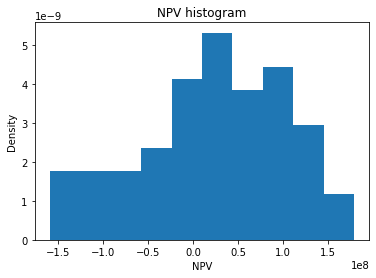

In [85]:
plt.title("NPV histogram")
plt.xlabel("NPV")
plt.ylabel("Density")
plt.hist(sim_default_df['npv'], density=True);

## Evaluate multiple scenarios
Now that the model is working for two random inputs and a multiperiod cash flow model, let's add a set of scenarios corresponding to different values of the fixed development cost.

In [87]:
scenario_inputs = {'fixed_dev_cost': [500e+6, 600e+6, 700e+6]}

In [88]:
sim_scenario_results = model_default.simulate(random_inputs, ['npv'], scenario_inputs)

In [89]:
sim_scenario_results

[{'scenario_base_vals': {'fixed_dev_cost': 600000000.0,
   'base_margin': 4000.0,
   'annual_margin_decr': 0.04,
   'yr1_demand': 53560,
   'demand_decr': array([[0.077, 0.077, 0.077, 0.077]]),
   'tax_rate': 0.21,
   'discount_rate': 0.07,
   'num_years': 5},
  'scenario_num': 0,
  'scenario_vals': {'fixed_dev_cost': 500000000.0},
  'output': {'npv': array([ 1.50776877e+08,  2.55276787e+07,  9.10542008e+07,  6.82808756e+07,
           1.62976611e+08,  2.01482648e+08,  8.74052271e+07,  1.43188890e+08,
           8.30293926e+07, -3.02399219e+07,  8.15966883e+07,  2.14366940e+08,
           1.48661982e+08, -2.61851844e+07,  5.69249533e+07,  1.35230326e+08,
           1.16503536e+08,  1.25572560e+07,  1.18955806e+08,  1.66853178e+08,
           1.30564782e+08,  3.96696175e+07,  1.82587612e+08, -3.43094880e+06,
           8.69495133e+07, -3.11957634e+06,  1.46481391e+08,  9.78755366e+07,
           3.39565647e+07,  1.15342321e+08,  7.19418829e+07,  1.01776680e+08,
          -7.65299954e+07

In [90]:
sim_scenario_df = get_sim_results_df(sim_scenario_results)
sim_scenario_df

,npv,scenario_num,fixed_dev_cost
0,1.507769e+08,0,500000000.0
1,2.552768e+07,0,500000000.0
2,9.105420e+07,0,500000000.0
3,6.828088e+07,0,500000000.0
4,1.629766e+08,0,500000000.0
...,...,...,...
95,8.074407e+07,2,700000000.0
96,-4.409879e+07,2,700000000.0
97,-5.079606e+07,2,700000000.0
98,9.629351e+07,2,700000000.0
